In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
current_path = '/content/drive/My Drive/Colab Notebooks/Project_GANder/gankook_cuda/semantic-segmentation-pytorch/pytorch_room_layout/'

import os
os.chdir(current_path)
!ls

 build		        info.json	        segment_st.py
 cv2_requirements.txt   lsun.pth.tar	       'sunrgbd (1).zip'
 datasets	        lu_vp_detect.egg-info   sunrgbd.pth.tar
 data_transforms.py     pics		        test_result
 dist		        __pycache__	        Vanish_Point_Detection
 drn_d_105_024_val      README.md	        visualize.m
 drn_d_105_024_val_ms   requirements.txt        XiaohuLuVPDetection
 drn.py		        segment_lsun.py
 features	        segment_rl.py


### Get Vanishing point, inliers

In [ ]:
# !python XiaohuLuVPDetection/setup.py build
# !python XiaohuLuVPDetection/setup.py install
!pip install -r cv2_requirements.txt

     |████████████████████████████████| 25.4MB 1.6MB/s 
     |████████████████████████████████| 31.2MB 184kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import cv2
cv2.__version__

'4.0.0'

### Functions

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from XiaohuLuVPDetection.lu_vp_detect.vp_detection import VPDetection
import time
# import os
import cv2
# import pylab as pl
from skimage import morphology as mp
import sys

In [ ]:
#             Detect Intersection             #
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sympy import Line
from sympy.geometry import Ray


def drawLines(img, lines, color=(255,255,255)):
    """
    Draw lines on an image
    """
    for line in lines:
        for rho,theta in line:
          a = np.cos(theta)
          b = np.sin(theta)
          x0 = a*rho
          y0 = b*rho
          x1 = int(x0 + 1000*(-b))
          y1 = int(y0 + 1000*(a))
          x2 = int(x0 - 1000*(-b))
          y2 = int(y0 - 1000*(a))

          slope = (y1 - y0) / float(x1 - x0)
          angle = math.degrees(math.atan(slope))
          # if abs(angle) < 70:
          cv2.line(img, (x1,y1), (x2,y2), color, 1)

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection2(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


def regression(img, x, y, color=(255, 0, 0), axis=1):

  if axis == 1:
    y_at_border = np.array([0, img.shape[0]])
    p = np.polyfit(y, x, deg=1)
    x_at_border = np.poly1d(p)(y_at_border)
  else:
    x_at_border = np.array([0, img.shape[1]])
    p = np.polyfit(x, y, deg=1)
    y_at_border = np.poly1d(p)(x_at_border)

  cv2.line(img, (int(x_at_border[0]), int(y_at_border[0])), (int(x_at_border[1]), int(y_at_border[1])), color, 2)

  return x_at_border, y_at_border


def find_reg_points(img, lines, color=(255,0,0), drawlines=False):

  centroids = list()
  r_xs = list()
  r_ys = list()
  for line_ in lines:
      for rho,theta in line_:
          a = np.cos(theta)
          b = np.sin(theta)
          x0 = a*rho
          y0 = b*rho
          x1 = int(x0 + 1000*(-b))
          y1 = int(y0 + 1000*(a))
          x2 = int(x0 - 1000*(-b))
          y2 = int(y0 - 1000*(a))

          slope = (y1 - y0) / float(x1 - x0)
          angle = math.degrees(math.atan(slope))
          if abs(angle) > 80:
            # print(img.shape[1])
            h_layout = line((0, 0), (img.shape[1], 0))
            h_layout_lower = line((0, img.shape[0]), (img.shape[1], img.shape[0]))
            r = intersection2(h_layout, line((x1, y1), (x2, y2)))
            r_lower = intersection2(h_layout_lower, line((x1, y1), (x2, y2)))
            # cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

            center_p = (int((r[0] + r_lower[0]) / 2), int((r[1] + r_lower[1])/ 2))
            centroids.append(center_p)

            r_xs.append((r[0], r_lower[0]))
            r_ys.append((r[1], r_lower[1]))

            if drawlines:
              cv2.line(img, (int(r[0]), int(r[1])), (int(r_lower[0]), int(r_lower[1])), color, 2)
              cv2.circle(img, center_p, 10, (255, 0, 255), -1)

  if drawlines:
    cv2.line(img, (int(0), int(0)), (int(0), int(img.shape[0])), color, 2)
    cv2.line(img, (int(img.shape[1]), int(0)), (int(img.shape[1]), int(img.shape[0])), color, 2)
    cv2.circle(img, (0, int(img.shape[0] / 2)), 10, (255, 0, 255), -1)
    cv2.circle(img, (img.shape[1], int(img.shape[0] / 2)), 10, (255, 0, 255), -1)
  centroids.append((0, int(img.shape[0] / 2)))
  centroids.append((img.shape[1], int(img.shape[0] / 2)))

  return r_xs, r_ys, centroids   

from scipy.spatial import distance as sci_dist

def order_points(pts):

  xSorted = pts[np.argsort(pts[:, 0]), :]
  leftMost = xSorted[:2, :]
  rightMost = xSorted[2:, :]
  leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
  (tl, bl) = leftMost
  D = sci_dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
  (br, tr) = rightMost[np.argsort(D)[::-1], :]

  return np.array([tl, tr, br, bl], dtype="float32")


def get_vline_points_inborder(vpd, img, show_vline=False):

  vpd.find_vps(img)
  # vps = vpd.vps_2D
  vl_img, vl_list = vpd.create_debug_VP_image(show_vl=True)


  vl_list_for_vline = vl_list
  vl_img_for_vline = vl_img.copy()

  # print('#       Used vl_list for vline work       #')
  # print('vl_list')
  # print()

  #           Extract Vertical line            #
  h_border = Line((0, 0), (img.shape[1], 0))
  h_border_lower = Line((0, img.shape[0]), (img.shape[1], img.shape[0]))

  reg_xs = list()
  reg_ys = list()
  v_lines = list()
  # h_lines_xrange = list()
  for vl in vl_list_for_vline:
      x0, y0, x1, y1 = vl
      slope = (y1 - y0) / float(x1 - x0)
      angle = math.degrees(math.atan(slope))
      # print(angle)
      if abs(angle) > 80:
        # cv2.line(skl_copy, (int(x1), int(y1)), (int(x0), int(y0)), (255, 0, 0), 3,
        #                  cv2.LINE_AA)
        v_line = Line((x0, y0), (x1, y1))
        [top_point] = v_line.intersection(h_border)
        [bot_point] = v_line.intersection(h_border_lower)
        # v_lines.append()
        reg_xs.append((float(top_point[0]), float(bot_point[0])))
        reg_ys.append((float(top_point[1]), float(bot_point[1])))

      # if abs(angle) < 70:
      #   h_lines_xrange.append((min(x0, x1), max(x0, x1)))


  # print('#        Before Sorting      #')
  # print('reg_xs :', reg_xs)
  
  
  center_xs = list()
  for reg_x, reg_y in zip(reg_xs, reg_ys):
    center_xs.append(np.mean(reg_x))
    #           Draw Line         #
    regression(vl_img_for_vline, reg_x, reg_y)
    
  if show_vline:
    plt.imshow(vl_img_for_vline)
    plt.title('Divided Session')
    plt.show()

  sorted_index = list()
  sorted_center_xs = sorted(center_xs)

  for center_x in sorted_center_xs:
    # print('center_x :', center_x)
    sorted_index.append(center_xs.index(center_x))
  print('sorted_index :', sorted_index)   #

  sorted_reg_xs = list()
  sorted_reg_ys = list()
  for s_index in sorted_index:
    sorted_reg_xs.append(reg_xs[s_index])
    sorted_reg_ys.append(reg_ys[s_index])
  reg_xs = sorted_reg_xs
  reg_ys = sorted_reg_ys

  print()
  # print("#        After Sorting       #")
  # print('reg_xs :', reg_xs)
  # print()

  return reg_xs


def remove_outlier_angle(vl_list, copy_vl_list, angle_list, limit_angle=15):

    if len(vl_list) != 0:
      copy_angle_list = angle_list.copy()
      mean_angle_list = np.array(angle_list).mean()
      # print('mean_angle_list :', mean_angle_list)
      # print('angle_list :', angle_list)
      print('max angle_list gap : ', max(angle_list) - mean_angle_list)

      for angle_index, angle in enumerate(copy_angle_list):
        if abs(angle - mean_angle_list) > limit_angle:
          vl_list.remove(copy_vl_list[angle_index])
          # angle_list.remove(copy_angle_list[angle_index])

      return

def get_hline_points_inborder(img, left_border, right_border, vl_list, top_vl, bot_vl, top_down_ratio=0.66):

  ex_top_vl = list()
  ex_bot_vl = list()

  for vl in vl_list:

    x0, y0, x1, y1 = vl
    l1 = Line((x0, y0), (x1, y1))
    #     v_border line     #
    [left_point] = l1.intersection(left_border)
    # print('left_point :', left_point)
    [right_point] = l1.intersection(right_border)

    #      Figure out current vl is top / bottom vl     #
    if vl in top_vl:
      if (left_point[1] < img.shape[0] * top_down_ratio and right_point[1] < img.shape[0] * top_down_ratio):
          ex_top_vl.append((left_point[0], left_point[1], right_point[0], right_point[1]))

    elif vl in bot_vl:
      if (left_point[1] > img.shape[0] * (1 - top_down_ratio) and right_point[1] > img.shape[0] * (1 - top_down_ratio)):
          ex_bot_vl.append((left_point[0], left_point[1], right_point[0], right_point[1]))

  return ex_top_vl, ex_bot_vl


def toppest_bottest_vl(img, top_vl, bot_vl, direction):

    max_y = 0
    min_y = img.shape[0]
    toppest_vl = None
    bottest_vl = None
    index = 1 if direction == 'right' else 3

    for vl in top_vl:
      if vl[index] < min_y:
        toppest_vl = vl
        min_y = vl[index]

    for vl in bot_vl:
      if vl[index] > max_y:
        bottest_vl = vl
        max_y = vl[index]

    return toppest_vl, bottest_vl


def line_mirroring(src_vl, src_point, left_border, right_border):

    x0, y0, x1, y1 = src_vl
    slope = (y1 - y0) / float(x1 - x0)
    angle = - math.degrees(math.atan(slope))

    #       white_max_y 를 - toppest_vl angle 로 지나는 직선      #
    print('src_point :', src_point)
    print('angle :', angle)
    endy = 100 * math.sin(math.radians(angle))
    endx = 100 * math.cos(math.radians(angle))
    temp_vl = Line(src_point, (src_point[0] + endx, src_point[1] + endy))
    [left_point] = temp_vl.intersection(left_border)
    [right_point] = temp_vl.intersection(right_border)
    # print('left_point :', left_point)
    mirrored_vl = (float(left_point[0]), float(left_point[1]), float(right_point[0]), float(right_point[1]))

    return mirrored_vl


def choose_4points(toppest_vl, bottest_vl, src_point, left_border, right_border, parallel):

  x1, y1, x0, y0 = toppest_vl
  if parallel:
    top_line = Line((x1, y1), (x0, y0))
    print('top_line.slope :', float(top_line.slope))            
    if abs(top_line.slope) < 0.05:
        src_point = (0, 0)
    parallel_tl = top_line.parallel_line(src_point)

    [tl] = parallel_tl.intersection(left_border)
    [tr] = parallel_tl.intersection(right_border)
    br, bl = bottest_vl[2:], bottest_vl[:2]
  else:
    tl, tr, br, bl = toppest_vl[:2], toppest_vl[2:], bottest_vl[2:], bottest_vl[:2]

  return tl, tr, br, bl


def top_bot_mask(mask_img, threshold=1/10):

    top_white_cnt = 0
    bot_white_cnt = 0
    white_min_x = mask_img.shape[1]
    white_max_x = 0
    white_min_y = mask_img.shape[0]
    white_max_y = 0
    temp_min_y = white_min_y
    temp_max_y = white_max_y
    min_x_coord, max_x_coord, min_y_coord, max_y_coord = None, None, None, None
    top_parallel = False
    bot_parallel = False
    for i in range(mask_img.shape[1]):

      #     Check Top Condition     #
      for j in range(int(mask_img.shape[0] * threshold)):
        # if mask_img[j][i] == 255 and j < thr_min_y:
          # thr_min_y = j
          # thr_min_y_coord = (i, j)
        if mask_img[j][i] == 255:
          top_white_cnt += 1
          if i > white_max_x:
            white_max_x = i
            max_x_coord = (i, j)
          if i < white_min_x:
            white_min_x = i
            min_x_coord = (i, j)

          if j < temp_min_y:
            temp_min_y = j
            temp_min_y_coord = (i, j)

      #           Middle Condition        #
      for j in range(int(mask_img.shape[0] * threshold), int(mask_img.shape[0] * (1 - threshold))):
        if mask_img[j][i] == 255:
          if j > white_max_y:
            white_max_y = j
            max_y_coord = (i, j)
          if j < white_min_y:
            white_min_y = j
            min_y_coord = (i, j)

      #     Check Bot Condition   #
      for j in range(int(mask_img.shape[0] * (1 - threshold)), mask_img.shape[0]):
        # if mask_img[j][i] == 255 and j < thr_min_y:
          # thr_min_y = j
          # thr_min_y_coord = (i, j)
        if mask_img[j][i] == 255:
          bot_white_cnt += 1
          if j > temp_max_y:
            temp_max_y = j
            temp_max_y_coord = (i, j)

    if top_white_cnt / (mask_img.shape[1] * int(mask_img.shape[0] * threshold)) > 0.5:
      top_parallel = True
      min_y_coord = temp_min_y_coord
    
    if bot_white_cnt / (mask_img.shape[1] * int(mask_img.shape[0] * threshold)) > 0.5:
      #     바닥은 평행 이동 사용하지 않는다.    #
      # bot_parallel = True
      max_y_coord = temp_max_y_coord

    return min_x_coord, max_x_coord, min_y_coord, max_y_coord, top_parallel, bot_parallel


def crop_and_warp(refer, vl_img, src_4p, dst_4p):


  #       Crop      #
  refered = np.asarray(refer)[:vl_img.shape[0], :vl_img.shape[1]]

  # plt.imshow(refered)
  # plt.title('refered')
  # plt.show()

  # compute the perspective transform matrix and then apply it
  matrix = cv2.getPerspectiveTransform(src_4p, dst_4p)
  refered = cv2.warpPerspective(refered, matrix, (refered.shape[1], refered.shape[0]))

  return refered

In [ ]:
#     Refering for one image data   #
def synthesize(org_image, refer_image, vpd, scale_factor=6, show_img=False):

  #       Layout Part       #
  # img = Image.open(layout_path + image)
  # # print(type(img))
  # img_np = np.invert(np.asarray(img))
  # # print(img_np.max(), img_np.min())
  # ret, thr = cv2.threshold(img_np, 254, 255, cv2.THRESH_BINARY_INV)

  #       Mask Part         #
  org_color_np, org_np = np.split(np.asarray(org_image), 2, axis=1)
  # org_np = np.asarray(org)
  # gray = cv2.cvtColor(org_np, cv2.COLOR_RGB2GRAY)
  # print(org_np.shape)
  # ret, thr = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

  print(image)
  # plt.subplot(131)
  # plt.imshow(org)
  # plt.show()
  img_size = (org_np.shape[1], org_np.shape[0])
  
  print('scale_factor :', scale_factor)

  # refer = Image.open(refer_path)
  refer = np.asarray(refer_image)

  #     refer_size와 img_size가 동일하거나 refer_size가 작은 경우를 고려해야한다.     #
  refer = np.tile(refer, (scale_factor, scale_factor, 1))
  size_ratio = math.floor(min((refer.shape[0] / (org_np.shape[0] * 1.5)), (refer.shape[1] / (org_np.shape[1] * 1.5))))
  refer = Image.fromarray(refer).resize((int(refer.shape[1] / size_ratio), int(refer.shape[0] / size_ratio)))

  org_color_np2 = org_color_np.copy()
  org_np = org_np.astype(np.uint8)
  org_np2 = org_np.copy()
  org_np3 = org_np.copy()

  start = time.time()


  #                   Find Best Vline_list                #
  kernel = np.ones((10, 10), np.uint8)

  org_np2_morp = cv2.morphologyEx(org_np2, cv2.MORPH_CLOSE, kernel)
  org_np2_copy = org_np2_morp.copy()
  # org_np2_copy_gray = cv2.cvtColor(org_np2_copy, cv2.COLOR_RGB2GRAY)

  ret, thr_org_np2 = cv2.threshold(org_np2_copy, 127, 255, cv2.THRESH_BINARY)
  thr_org_np2 = cv2.morphologyEx(thr_org_np2, cv2.MORPH_CLOSE, kernel)
  thr_org_np2_copy = thr_org_np2.copy()
  
  edge_org_np2 = cv2.Canny(org_np2_morp, 20, 100)
  edge_org_np2_copy = edge_org_np2.copy()
  edge_org_np2_copy2 = cv2.Canny((org_np2_copy / 255. * org_np2_copy).astype(np.uint8), 20, 60)
  
  reg_xs = get_vline_points_inborder(vpd, edge_org_np2_copy2)
  print('#            Used vl_list for vline work          #')
  print('edge_org_np2_copy2')
  print()

  #                                     Find Best Hline                                      #
  #     vline 이 존재하지 않는 경우도 고려해야한다.     #
  if len(reg_xs) == 0:
    reg_xs.append([0, 0])
    # reg_ys.append([0, org_np2.shape[0]])
    
  #         Divide Session by vline       #
  for reg_index, reg_x in enumerate(reg_xs):


    #     In a Session     #
    #     1.  find vanishing point    #
    #     2.  Find 3 points (vp, top & bottom points)     #
    #     3.  Do warfine and attach to the black plane      #

    print("#      Session Status      #")
    print('reg_index, reg_x :', reg_index, reg_x)
    
    #     0.  crop by vline     #
          #   Find Max_x, min_x, (Max_y, min_y = org.shape[0], 0)
          #   1.    우편에 한해서 max_x = 우편 vline max_x & min_x = 현재 vline min_x
          #   2.    좌편에 한해서 max_x = 현재 Max_x & min_x = 좌편 vline min_x

    #      vline 별로 양옆으로 작업을 하면 len(vline) = 1의 작업을 반복할 필요가 없어진다.    #
    iter = False
    while True:

      #                   We need Max, min x & y                #
      # four_inters = list()
      find_pair = True
      # centroid_inters = all_centroid_inters[inters_i]

      if not iter:

        #       오른쪽 끝 vline 이면        #
        if reg_index == len(reg_xs) - 1:
          print('rightest vline')
          #   1.    우편에 한해서 max_x = 우편 vline max_x & min_x = 현재 vline min_x
          max_x = org_np.shape[1]
          min_x = np.min(reg_x)

        else:
          print('middle vline')
          next_reg_x = reg_xs[reg_index + 1]
          max_x = np.max(next_reg_x)
          if np.min(reg_x) < 0:
            min_x = 0
          else:
            min_x = np.min(reg_x)

      #     i = 0 에 한해서만 왼쪽으로도 refering 진행, 나머지는 오른쪽으로만     #
      else:
          #   2.    좌편에 한해서 max_x = 현재 Max_x & min_x = 좌편 vline min_x
          max_x = np.max(reg_x)
          min_x = 0

      print('min_x, max_x :', min_x, max_x)
      # max_y = org_np.shape[0]
      # min_y = 0

      #     Make Session      #
      session = org_np2[:, int(min_x):int(max_x)]
      # plt.imshow(session)
      # plt.show()


      if (max_x - min_x) > 50:
        length_thresh = 50
      else:
        length_thresh = 20
        if max_x - min_x < 20:
            #     i != 0 인 경우 break     #
          if reg_index == 0 and np.sum(reg_xs) != 0 and not iter:
            iter = True
            print('iter :', iter)
            continue
          else:
            break
      
      principal_point = None
      focal_length = 1300 # 1102.79
      seed = None
      vpd = VPDetection(length_thresh, principal_point, focal_length, seed)

      try:
        vpd.find_vps(session)
        # vps = vpd.vps_2D
        vl_img, vl_list = vpd.create_debug_VP_image(show_vl=True)


        #       Closing Morphing by OpenCV      #
        kernel = np.ones((10, 10), np.uint8)
        session = cv2.morphologyEx(session, cv2.MORPH_CLOSE, kernel)

        #     Before Canny    #
        session_prob = session / 255.

        #     Multiply mask map with Edge => Erase Unnecessary vl line    #
        #   multiply one time   #
        session2 = session_prob * (session)
        edge_session2 = cv2.Canny(session2.astype(np.uint8), 20, 60)
        #       two time      #
        # session2 = session_prob**2 * (session)
        # edge_session2 = cv2.Canny(session2.astype(np.uint8), 20, 60)

        vpd.find_vps(edge_session2)
        # vps = vpd.vps_2D      
        vl_edge_img2, vl_edge_list2 = vpd.create_debug_VP_image(show_vl=True)
      
      except Exception as e:
        print("Error in vpd Sessions Zone :", e)
        print()
          #     i != 0 인 경우 break     #
        if reg_index == 0 and np.sum(reg_xs) != 0 and not iter:
          iter = True
          print('iter :', iter)
          continue

        else:
          break


      #         What is best vl_list      #
      vl_list = vl_edge_list2
      print('#            Used vl_list for hline work          #')
      print('vl_edge_list2')
      print()

      h_lines = list()
      # print('vps :', vps)

      top_vl = list()
      bot_vl = list()

      left_vl_list = list()
      right_vl_list = list()

      left_angle = list()
      right_angle = list()

      for vl in vl_list:
        x0, y0, x1, y1 = vl
        slope = (y1 - y0) / float(x1 - x0)
        angle = math.degrees(math.atan(slope))

        if abs(angle) < 70:
          if (y0 + y1) / 2 < vl_img.shape[0] / 2:
            # print(y0, y1)
            top_vl.append(vl)
            if angle < 0:
              left_vl_list.append(vl)
              left_angle.append(abs(angle))
            else:
              right_vl_list.append(vl)
              right_angle.append(abs(angle))
          else:
            bot_vl.append(vl)
            if angle > 0:
              left_vl_list.append(vl)
              left_angle.append(abs(angle))
            else:
              right_vl_list.append(vl)
              right_angle.append(abs(angle))
          # cv2.line(skl_copy, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 2,
          #                  cv2.LINE_AA)
          h_lines.append(vl)
        #   regression(vl_img, (x0, x1), (y0, y1), color=(0,255,255),axis=1)
        
      print('#        Original vl list        #')
      print('len(left_vl_list) :', len(left_vl_list))
      print('len(right_vl_list) :', len(right_vl_list))
      print()

      #             소실점 방향 선택            #
      #       original vl_list 는 remove 가 존재하기 때문에 copy_ version 사용한다.       #
      copy_left_vl_list = left_vl_list.copy()
      copy_right_vl_list = right_vl_list.copy()
      print('len(copy_left_vl_list) :', len(copy_left_vl_list))
      print('len(copy_right_vl_list) :', len(copy_right_vl_list))

      if len(copy_left_vl_list) >= len(copy_right_vl_list):
        direction = 'left'
        vl_list, copy_vl_list, angle = left_vl_list, copy_left_vl_list, left_angle
      else:
        direction = 'right'
        vl_list, copy_vl_list, angle = right_vl_list, copy_right_vl_list, right_angle


      print("#            Remove Outliered Angle in Hlines           #")
      remove_outlier_angle(vl_list, copy_vl_list, angle)
      # remove_outlier_angle(right_vl_list, copy_right_vl_list, right_angle)
      print()

      print('len(left_vl_list) :', len(left_vl_list))
      print('len(right_vl_list) :', len(right_vl_list))
      print()

      
      # if len(left_vl_list) == 0 and len(right_vl_list) == 0:
      if len(vl_list) == 0:
        #     i != 0 인 경우 break     #
        if reg_index == 0 and not iter:
          iter = True
          print('iter :', iter)
          continue

        else:
          break
      
      #                       Find External vn_line                     #
      # h_border_top = Line((0, 0), (vl_img.shape[1], 0))
      # h_border_bot = Line((0, vl_img.shape[0]), (vl_img.shape[1], vl_img.shape[0]))
      l2 = Line((0, 0), (0, vl_img.shape[0]))
      l3 = Line((vl_img.shape[1], 0), (vl_img.shape[1], vl_img.shape[0]))

      ex_top_vl, ex_bot_vl = get_hline_points_inborder(vl_img, l2, l3, vl_list, top_vl, bot_vl)
      # ex_left_top_vl, ex_left_bot_vl = get_hline_points_inborder(vl_img, l2, l3, left_vl_list, top_vl, bot_vl)
      # ex_right_top_vl, ex_right_bot_vl = get_hline_points_inborder(vl_img, l2, l3, right_vl_list, top_vl, bot_vl)
          

      print()
      print('#          Extended vl list left / right  TB Condition        #')
      print('len(ex_top_vl) :', len(ex_top_vl))
      print('len(ex_bot_vl) :', len(ex_bot_vl))
      # print('len(ex_left_top_vl) :', len(ex_left_top_vl))
      # print('len(ex_left_bot_vl) :', len(ex_left_bot_vl))
      # print('len(ex_right_top_vl) :', len(ex_right_top_vl))
      # print('len(ex_right_bot_vl) :', len(ex_right_bot_vl))
      print()

      #       find min max Line     #
      toppest_vl, bottest_vl = toppest_bottest_vl(vl_img, ex_top_vl, ex_bot_vl, direction)
      # right_toppest_vl, right_bottest_vl = toppest_bottest_vl(vl_img, ex_right_top_vl, ex_right_bot_vl, 'right')
      # left_toppest_vl, left_bottest_vl = toppest_bottest_vl(vl_img, ex_left_top_vl, ex_left_bot_vl, 'left')


      #       Figure out min_y & max_y of thr_session       #
      # print('thr_session.shape :', thr_session.shape)
      gray = cv2.cvtColor(session, cv2.COLOR_RGB2GRAY)
      ret, thr_session = cv2.threshold(session, 127, 255, cv2.THRESH_BINARY)
      thr_session = cv2.morphologyEx(thr_session, cv2.MORPH_CLOSE, kernel)
      thr_session_gray = cv2.cvtColor(thr_session, cv2.COLOR_RGB2GRAY)
      print('thr_session_gray.shape :', thr_session_gray.shape)

      min_x_coord, max_x_coord, min_y_coord, max_y_coord, top_parallel, _ = top_bot_mask(thr_session_gray)
      
      
      print('max_x_coord, min_x_coord :', max_x_coord, min_x_coord)
      print('max_y_coord, min_y_coord :', max_y_coord, min_y_coord)

      try:

        #     None 이라면 대칭이동을 통해 만들어주어야한다.     #
        if len(ex_bot_vl) == 0:
          if toppest_vl is not None:
            bottest_vl = line_mirroring(toppest_vl, max_y_coord, l2, l3)
            print('bottest_vl :', bottest_vl)

        elif len(ex_top_vl) == 0:
          if bottest_vl is not None:
            toppest_vl = line_mirroring(bottest_vl, min_y_coord, l2, l3)
            print('toppest_vl :', toppest_vl)

        # if len(ex_right_bot_vl) == 0:
        #   if right_toppest_vl is not None:
        #     right_bottest_vl = line_mirroring(right_toppest_vl, max_y_coord, l2, l3)
        #     print('right_bottest_vl :', right_bottest_vl)

        # elif len(ex_right_top_vl) == 0:
        #   if right_bottest_vl is not None:
        #     right_toppest_vl = line_mirroring(right_bottest_vl, min_y_coord, l2, l3)
        #     print('right_toppest_vl :', right_toppest_vl)

        # if len(ex_left_bot_vl) == 0:
        #   if left_toppest_vl is not None:
        #     left_bottest_vl = line_mirroring(left_toppest_vl, max_y_coord, l2, l3)
        #     print('left_bottest_vl :', left_bottest_vl)

        # elif len(ex_left_top_vl) == 0:
        #   if left_bottest_vl is not None:
        #     left_toppest_vl = line_mirroring(left_bottest_vl, min_y_coord, l2, l3)
        #     print('left_toppest_vl :', left_toppest_vl)

        for (x1, y1, x0, y0) in [toppest_vl, bottest_vl]:
          cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)
        # for (x1, y1, x0, y0) in [right_toppest_vl, right_bottest_vl]:
        #   cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)
        # for (x1, y1, x0, y0) in [left_toppest_vl, left_bottest_vl]:
        #   cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (255, 255, 0), 3, cv2.LINE_AA)
      except Exception as e:
        print('Error in drawing top, bot -est lines :', e)
      
        #     i != 0 인 경우 break     #
        if reg_index == 0 and not iter:
          iter = True
          print('iter :', iter)
          continue

        else:
          break
        

      #               Choose 4 points             #
      tl, tr, br, bl = choose_4points(toppest_vl, bottest_vl, min_x_coord, l2, l3, top_parallel)

      # if len(copy_left_vl_list) >= len(copy_right_vl_list):
      #   #       toppest & bottest vl should be on the min_y & max_y of white mask       #
      #   tl, tr, br, bl = choose_4points(left_toppest_vl, left_bottest_vl, min_x_coord, top_parallel)
      # else:
      #   tl, tr, br, bl = choose_4points(right_toppest_vl, right_bottest_vl, min_x_coord, top_parallel)
        
      #       Refering      #
      #   tl, tr, br, bl    #
      #     refer를 위해 src_x => 0 으로 맞춰준다.    #
      src = np.array([
          [0, 0],
          [vl_img.shape[1], 0],
          [vl_img.shape[1], vl_img.shape[0]],
          [0, vl_img.shape[0]]], dtype = "float32")
      dst = np.array([list(tl),
                      list(tr),
                      list(br),
                      list(bl)], dtype = "float32")

      print()
      print("#          Warping Points        #")
      print('src :', src)
      print('dst :', dst)

      refered = crop_and_warp(refer, vl_img, src, dst)
      
      
      # plt.subplot(121)
      # plt.imshow(vl_img)
      # plt.title('Session_vl_img')
      # # plt.xlim(np.min(vps[:, [0]]), np.max(vps[:, [0]]))
      # # plt.ylim(np.min(vps[:, [1]]), np.max(vps[:, [1]]))
      # plt.subplot(122) 
      # plt.imshow(refered)
      # plt.show() 

      org_color_np2[:, int(min_x):int(max_x)] = refered


      #     i != 0 인 경우 break     #
      if reg_index == 0 and np.sum(reg_xs) != 0 and not iter:
        iter = True
        print('iter :', iter)

      else:
        break

  
  #         Refer의 검은 부분은 original image로 채운다.       #
  org_color_np2 = np.where(org_color_np2 == 0, org_color_np, org_color_np2)
  
  print('elapsed time :', time.time() - start)
  print()


  # print('np.max(org_np) :', np.max(org_np))
  org_np = org_np / 255.
  refer = org_color_np2
  # plt.show()

  #     1.wall_mask * reference color image + (1 - wall_mask) * original_image)    #
  syn_ = org_np * (refer) + (1 - org_np) * org_color_np
  syn = org_np * syn_ + (1 - org_np) * org_color_np

  #       Brightness Preservation      #
  org_hsv = cv2.cvtColor(np.uint8(org_color_np), cv2.COLOR_RGB2HSV)
  syn_hsv = cv2.cvtColor(np.uint8(syn), cv2.COLOR_RGB2HSV)

  org_h, org_s, org_v = cv2.split(org_hsv)
  syn_h, syn_s, syn_v = cv2.split(syn_hsv)

  mask_map = org_np[:, :, 0]
  # print(mask_map.shape)

  w = org_v / 255.
  w = w / 1.87
  syn_v2 = mask_map * syn_v + (1 - mask_map) * org_v
  syn_v2 = (1 - w) * syn_v2 + w * org_v
  syn_v2 = syn_v2.astype(np.uint8)

  final_syn_hsv = cv2.merge([syn_h, syn_s, syn_v2])
  final_syn = cv2.cvtColor(final_syn_hsv, cv2.COLOR_HSV2RGB)
  
  if show_img:

    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.imshow(org_np3)

    plt.subplot(132)
    plt.imshow(org_color_np2)

    plt.subplot(133)
    plt.imshow(final_syn)
    plt.show()

  return final_syn

720x480_20191004110915620_aVLsnTL8a4.png
scale_factor : 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: RuntimeWarning: divide by zero encountered in true_divide


sorted_index : [21, 20, 8, 5, 27, 16, 15, 24, 12, 26, 32, 19, 29, 30, 23, 11, 18, 7, 14, 10, 28, 9, 3, 31, 33, 25, 13, 22, 4, 6, 2, 1, 0, 17]

#            Used vl_list for vline work          #
edge_org_np2_copy2

#      Session Status      #
reg_index, reg_x : 0 (0.05656481289410886, 2.5383128231859327)
middle vline
min_x, max_x : 0.05656481289410886 2.3435808401663474
iter : True
min_x, max_x : 0 2.5383128231859327
#      Session Status      #
reg_index, reg_x : 1 (2.3435808401663474, 1.5050131473613704)
middle vline
min_x, max_x : 1.5050131473613704 3.3817079608629146
#      Session Status      #
reg_index, reg_x : 2 (3.3817079608629146, 1.0396013096682315)
middle vline
min_x, max_x : 1.0396013096682315 39.61394726852946
#            Used vl_list for hline work          #
vl_edge_list2

#        Original vl list        #
len(left_vl_list) : 2
len(right_vl_list) : 2

len(copy_left_vl_list) : 2
len(copy_right_vl_list) : 2
#            Remove Outliered Angle in Hlines           #
max 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: divide by zero encountered in true_divide


#            Used vl_list for hline work          #
vl_edge_list2

#        Original vl list        #
len(left_vl_list) : 0
len(right_vl_list) : 1

len(copy_left_vl_list) : 0
len(copy_right_vl_list) : 1
#            Remove Outliered Angle in Hlines           #
max angle_list gap :  0.0

len(left_vl_list) : 0
len(right_vl_list) : 1


#          Extended vl list left / right  TB Condition        #
len(ex_top_vl) : 0
len(ex_bot_vl) : 1

thr_session_gray.shape : (480, 36)
max_x_coord, min_x_coord : None None
max_y_coord, min_y_coord : (0, 338) (0, 185)
src_point : (0, 185)
angle : 8.051599531316576
toppest_vl : (0.0, 185.0, 36.0, 190.09253555454364)

#          Warping Points        #
src : [[  0.   0.]
 [ 36.   0.]
 [ 36. 480.]
 [  0. 480.]]
dst : [[  0.      185.     ]
 [ 36.      190.09253]
 [ 36.      329.58514]
 [  0.      334.6777 ]]
#      Session Status      #
reg_index, reg_x : 18 (221.4248521249793, 220.4538533571179)
middle vline
min_x, max_x : 220.4538533571179 533.506212151177

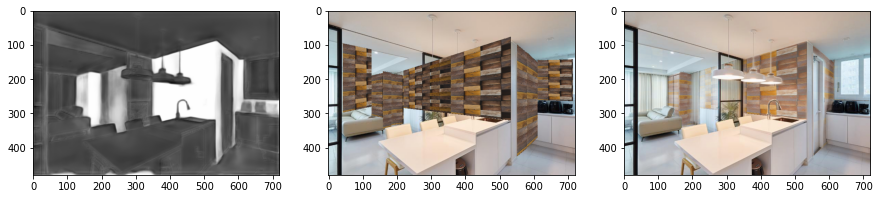

In [ ]:
if __name__ == '__main__':

  org_path = 'datasets/lsun/images/' # -> original image
  layout_path = 'drn_d_105_024_val_ms/images/' # -> layout image (result image frome above model file)
  refer_path = '../refer_data/wall/myxkehu1kfzggursepnk0tfiyps8zbs5umvzv8d92r6hhxejgawebwsufssgov5q-.jpg'

  object_ = 'wall'
  mask_path = '../test_data/' + object_ + '/'
  # layout_path = '../test_layout_result/' + object_ + '/'
  # layout_path = '../mask_layout_data/' + object_ + '/'
  # layout_list = os.listdir(layout_path)

  refer_path = './refer_data/' + object_ + '/'



  length_thresh = 70
  principal_point = None
  focal_length = 1300 # 1102.79
  seed = 1300
  vpd = VPDetection(length_thresh, principal_point, focal_length, seed)


  for image in os.listdir(mask_path):

    for refer in os.listdir(refer_path):

      try:
        
        image = '720x480_20191004110915620_aVLsnTL8a4.png'

        org = Image.open(mask_path + image)
        refer = Image.open(refer_path + refer)
        synthesize(org, refer, vpd)

      except Exception as e:
        print('Error in load images :', e)

      # break


In [ ]:
6.486232280731201
elapsed time : 6.074836015701294
elapsed time : 6.072072744369507
elapsed time : 6.072662591934204
elapsed time : 6.140763998031616
---
elapsed time : 4.42145848274231
elapsed time : 4.432448148727417
elapsed time : 4.47941255569458
---
elapsed time : 2.750857353210449
elapsed time : 2.7681655883789062
elapsed time : 2.7948927879333496
elapsed time : 2.882319927215576

